In [1]:
# 1. 데이터 확보
# 압축 풀기
import zipfile
filepath = 'data/glaucoma.zip'
with zipfile.ZipFile(filepath, 'r') as f:
    f.extractall('data/')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
                      rotation_range     = 20,   # 최대 회전 각도
                      width_shift_range  = .2,   # 가로 방향 이동, 가로 크기의 -20% ~ 20% 범위 내
                      height_shift_range = .2,   # 세로 방향 이동, 세로 크기의 -20% ~ 20% 범위 내
                      horizontal_flip    = True, # 수평 뒤집기
                      vertical_flip      = True, # 수직 뒤집기
                  )
train_data = train_generator.flow_from_directory(
    'data/glaucoma/train',
    target_size = (224, 224),
    batch_size  = 4,        # GPU 2000대 이상이면 생략 가능
    class_mode  = 'sparse', # 종속변수에 One-Hot Encoding 안 함
)
test_generator = ImageDataGenerator()
test_data = test_generator.flow_from_directory(
    'data/glaucoma/test',
    target_size = (224, 224),
    batch_size  = 4, 
    class_mode  = 'sparse', # 종속변수에 One-Hot Encoding 안 함
)

Found 828 images belonging to 3 classes.
Found 320 images belonging to 3 classes.


In [4]:
# Train / Test Dataset이 될 Image의 channel 확인
# image를 Numpy Array로 가져오기
img = image.load_img('data/glaucoma/test/normal_control/1.png') # Image 타입
img_data = image.img_to_array(img) # Numpy로 변환
img_data.shape

(240, 240, 3)

In [6]:
# 2. Model 생성
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np
from tensorflow.keras.models import Sequential # ResNet50의 Dense층을 사용자 추가
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image # 이미지 읽어오기

resnet_model = ResNet50(
                    input_shape = (224, 224, 3),
                    include_top = False) # Convolution과 Pooling Layer의 구조와 가중치를 가져옴
resnet_model.trainable = True # ResNet의 가중치도 update 가능
# model = Sequential()
# model.add(resnet_model)
# model.add(Flatten())
# model.add(Dense(units = 1024, activation = 'relu'))
# model.add(Dense(units = 3, activation = 'softmax'))
model = Sequential([
    resnet_model,
    Flatten(),
    Dense(units = 512, activation = 'relu'),
    Dense(units = 3, activation = 'softmax')
])
model.summary()
# 학습 시 필요한 용량
    # 1. Parameter Memory Usage: params(126,352,259개)*4byte(float) / 1024^2 = 482MB
    # 2. batch_size = 3일 경우, 3*(224 x 224 x 3)*4byte / 1024^2 = 19MB
    # 3. 각 layer층마다 활성화 값

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               51380736  
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 74,969,987
Trainable params: 74,916,867
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
# 3. Training Process Setting
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']) # recall, precision
# 4. Training
model.fit(train_data, 
          validation_data = test_data,
          epochs = 20, 
          batch_size = 1)

Epoch 1/20
207/207 [==============================] - 47s 154ms/step - loss: 3.5998 - accuracy: 0.5242 - val_loss: 2.9779 - val_accuracy: 0.2969
Epoch 2/20
207/207 [==============================] - 31s 149ms/step - loss: 0.8894 - accuracy: 0.6449 - val_loss: 2.0984 - val_accuracy: 0.6687
Epoch 3/20
207/207 [==============================] - 31s 150ms/step - loss: 0.7725 - accuracy: 0.6824 - val_loss: 1.8545 - val_accuracy: 0.6594
Epoch 4/20
207/207 [==============================] - 31s 151ms/step - loss: 0.8068 - accuracy: 0.6667 - val_loss: 5.2297 - val_accuracy: 0.6313
Epoch 5/20
207/207 [==============================] - 31s 149ms/step - loss: 0.6715 - accuracy: 0.6800 - val_loss: 2.8156 - val_accuracy: 0.6656
Epoch 6/20
207/207 [==============================] - 31s 149ms/step - loss: 0.6622 - accuracy: 0.7186 - val_loss: 1.4977 - val_accuracy: 0.6500
Epoch 7/20
207/207 [==============================] - 31s 150ms/step - loss: 0.6745 - accuracy: 0.6944 - val_loss: 0.8283 - val_ac

In [12]:
# Model 평가
model.evaluate(test_data)

80/80 [==============================] - 3s 37ms/step - loss: 1.2857 - accuracy: 0.6844


[1.285661220550537, 0.684374988079071]

1/1 [==============================] - 1s 1s/step
[[0.5004823 0.4954809 0.0040368]]
[0]


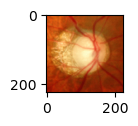

In [9]:
# 예측하기 (keras.preprocessing.image 이용)
img = image.load_img('data/test.png', target_size = (224, 224)) # Image 객체로 가져옴
x = image.img_to_array(img) # (240, 240, 3)
x = x.reshape(-1, 224, 224, 3)
pred = model.predict(x)
print(pred)

print(pred.argmax(axis = 1))
import matplotlib.pyplot as plt
plt.figure(figsize = (1, 1))
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 39ms/step
[[0.5004823 0.4954809 0.0040368]]
[0]


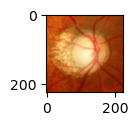

In [11]:
# 예측하기 (openCV 이용)
import cv2
img = cv2.imread('data/test.png', cv2.IMREAD_ANYCOLOR) # BGR Format Numpy
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 240 x 240 x 3
img = cv2.resize(img, dsize = (224, 224))
x = x.reshape(-1, 224, 224, 3)
pred = model.predict(x)
print(pred)

print(pred.argmax(axis = 1))
import matplotlib.pyplot as plt
plt.figure(figsize = (1, 1))
plt.imshow(img)
plt.show()